In [14]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph LR;
    A["True Sky"] --> B["Degridding"];
    D["Interferometer Config"] --> B["Degridding"];
    B --> C["Visibility"];
""")


# Generating visibilities from custom true sky image

This notebook aim to generate visibilities from custom "true" sky image with the standard dataflow degridding method.


## std_degridding() principle
Degridding is a key stage in the imaging process, where the values of a regular grid are interpolated to irregular points (the visibilities).

#### üîé The std_degridding consist in:
- Take an `input_grid` containing the transformed data.
- Extract (interpolate) the values at specific positions defined by the `corrected_vis_uvw_coords`.
- Apply a correction via an interpolation `kernel`.
- Store the result in `output_visibilities`.


#### üß± Function parameters:

```c
void std_degridding(
 int GRID_SIZE, // Grid size (GRID_SIZE x GRID_SIZE)
 int NUM_VISIBILITIES, // Total number of visibilities to process
 int NUM_KERNELS, // Total number of kernels available
 int TOTAL_KERNEL_SAMPLES,          // Total number of samples in the kernels array
 int OVERSAMPLING_FACTOR, // Oversampling factor for fine interpolation
 PRECISION2* kernels, // Array containing kernel samples
 int2* kernel_supports,             // Table containing the kernel supports
 PRECISION2* input_grid, // Table containing the input grid
 PRECISION3* corrected_vis_uvw_coords, // Table containing the corrected UVW coordinates
 int* num_corrected_visibilities, // Number of corrected visibilities to process
 Config* config, // Global configuration (UV and W scales)
 PRECISION2* output_visibilities // Output table containing the extracted visibilities
)
```

#### Complexity O(n):

Degridding can be time-consuming depending on certain parameters, which are worth revealing.
The complexity of this calculation is dominated by three nested loops:

$O(n_v . n_{\mathcal{D}}¬≤)$, where:

- $n_v$ is the number of corrected visibilities (or `*num_corrected_visibilities`),
- $n_{\mathcal{D}}$ is a measure of the size of the kernel (or more precisely half the size of the kernel support on each axis).

This means that the complexity of the calculation increases quadratically with the size of the kernel support and linearly with the number of corrected visibilities.

To better understand the complexity of the calculation, we need to configure its inputs and analyze the output.

# Notebook steps:

1. Generer un image avec pour parametre: `GRID_SIZE`, `NUM_SOURCE`.
2. Exporter au format *.csv pour faciliter la lecture en C.
3. Generer les noyaux de convolution avec pour parametre: `NUM_KERNEL`, `OVERSAMPLING_FACTOR`. 
4. Executer `./STD_DEGRID`.
5. Afficher les visibilit√©s g√©n√©r√©es sur le plan $uv$.

*Before starting, here is an example of visibility from the GLEAM dataset (access [here](https://nasext-vaader.insa-rennes.fr/ietr-vaader/)). The GLEAM dataset provides low-frequency radio observations, which are useful for testing degridding accuracy.*

/home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator
Min u : -30231.426923, Max u : 17860.497452
Min v : -22804.830289, Max v : 27478.047105
Min r√©el : -10.4285581666273, Max r√©el : 12.0908793522638
Min imaginaire : -11.6353456899264, Max imaginaire : 10.5571324792557
Maximum d'amplitude : 13.367794202018839


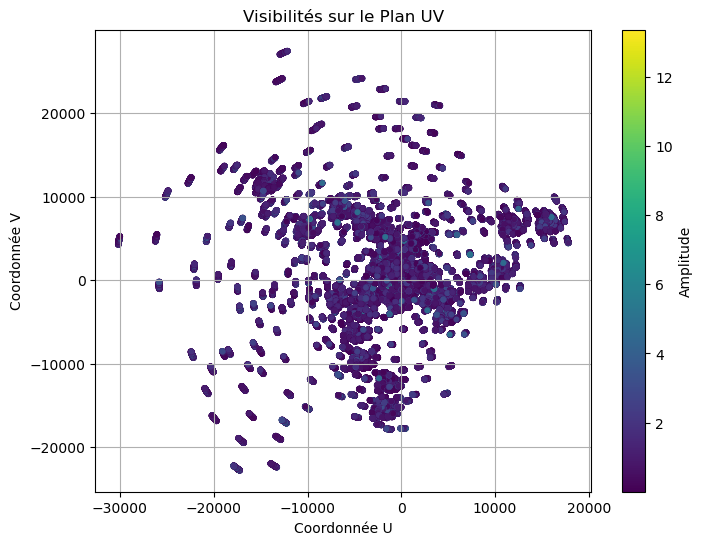

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os


current_directory = os.getcwd()
print(current_directory)

if not current_directory.endswith("vis-generator"):
    os.chdir("..")

# Charger les donn√©es depuis le fichier CSV
visibility_data = np.genfromtxt("example/GLEAM_small_visibilities_corrupted.csv", delimiter=' ', skip_header=1)

# Extraire les coordonn√©es u et v (ici j'utilise des colonnes fictives pour u et v, adaptez selon votre structure)
u_coord = visibility_data[:, 0]  # Premi√®re colonne : coordonn√©es u
v_coord = visibility_data[:, 1]  # Deuxi√®me colonne : coordonn√©es v

print(f"Min u : {np.min(u_coord)}, Max u : {np.max(u_coord)}")
print(f"Min v : {np.min(v_coord)}, Max v : {np.max(v_coord)}")


# Extraire les parties r√©elle et imaginaire des visibilit√©s
real_part = visibility_data[:, 3]  # 4e colonne : partie r√©elle
imag_part = visibility_data[:, 4]  # 5e colonne : partie imaginaire

print(f"Min r√©el : {np.min(real_part)}, Max r√©el : {np.max(real_part)}")
print(f"Min imaginaire : {np.min(imag_part)}, Max imaginaire : {np.max(imag_part)}")

# Calculer l'amplitude
amplitude = np.sqrt(real_part**2 + imag_part**2)

# **Afficher le maximum d'amplitude**
max_amplitude = np.max(amplitude)
print(f"Maximum d'amplitude : {max_amplitude}")

#print(visibility_data[:5])
#print(u_coord.dtype, v_coord.dtype)




# Tracer les visibilit√©s sur le plan UV
plt.figure(figsize=(8, 6))
plt.scatter(u_coord, v_coord, c=amplitude, cmap='viridis', s=10)  # Taille et couleur selon l'amplitude
plt.colorbar(label='Amplitude')  # Ajouter une barre de couleurs pour l'amplitude
plt.title("Visibilit√©s sur le Plan UV")
plt.xlabel("Coordonn√©e U")
plt.ylabel("Coordonn√©e V")
plt.grid(True)
plt.show()
os.chdir("dataflow_simulator/code")


#### Step 1: run the custom script to generate a custom *.fits

Taille de la grille : 512
Nombre de sources : 3
Fichier FITS g√©n√©r√© : code/radioastro.fits


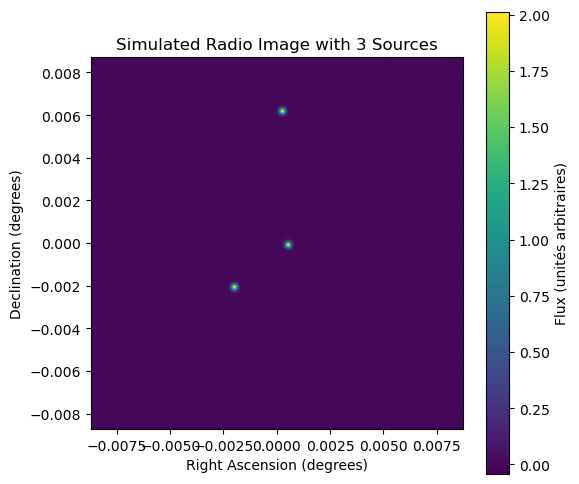

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import math

def generate_fits(size, num_sources, cell_size, output_file='code/radioastro.fits'):
    # Cr√©e une grille avec un bruit de fond gaussien
    data = np.random.normal(loc=0.0, scale=0.01, size=(size, size))

    # Param√®tres de la source
    source_amplitude = 2.0   # Intensit√© de la source
    source_sigma = 3.0       # Largeur de la gaussienne (en pixels)

    # G√©n√®re des sources al√©atoires
    for _ in range(num_sources):
        x = np.random.randint(0, size)
        y = np.random.randint(0, size)
        
        # Cr√©e une source gaussienne
        for i in range(size):
            for j in range(size):
                data[i, j] += source_amplitude * np.exp(-((i - x)**2 + (j - y)**2) / (2 * source_sigma**2))

    # Cr√©e le fichier FITS avec les m√©tadonn√©es
    hdu = fits.PrimaryHDU(data)

    # Met √† jour l'en-t√™te avec les infos physiques
    hdu.header['CDELT1'] = -cell_size / np.sqrt(2)  # Taille du pixel en degr√©s (axe x)
    hdu.header['CDELT2'] = cell_size / np.sqrt(2)   # Taille du pixel en degr√©s (axe y)
    hdu.header['CRPIX1'] = size / 2    # Pixel de r√©f√©rence (centre)
    hdu.header['CRPIX2'] = size / 2
    hdu.header['CRVAL1'] = 0.0         # Coordonn√©e centrale en degr√©s
    hdu.header['CRVAL2'] = 0.0
    hdu.header['CTYPE1'] = 'RA---SIN'  # Type de projection
    hdu.header['CTYPE2'] = 'DEC--SIN'

    hdul = fits.HDUList([hdu])
    
    # Sauvegarde le fichier FITS
    hdul.writeto(output_file, overwrite=True)
    print(f"Fichier FITS g√©n√©r√© : {output_file}")

    # Affiche l'image
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='viridis', origin='lower',
               extent=[-size * cell_size / 2, size * cell_size / 2,
                       -size * cell_size / 2, size * cell_size / 2])
    plt.colorbar(label='Flux (unit√©s arbitraires)')
    plt.title(f'Simulated Radio Image with {num_sources} Sources')
    plt.xlabel('Right Ascension (degrees)')
    plt.ylabel('Declination (degrees)')
    plt.show()

if __name__ == "__main__":
    GRID_SIZE = int(input("Taille de la grille : ")) # ex: 512
    NUM_SOURCES = int(input("Nombre de sources : ")) # ex: 3
    FOV_DEGREES =1;
    cell_size = (FOV_DEGREES * math.pi) / (180.0 * GRID_SIZE)
    generate_fits(GRID_SIZE, NUM_SOURCES, cell_size)


#### Step 2 convert *.fits to *.csv

In [14]:
import numpy
import sys
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

def write_nparr_to_csv(data, filename, delimiter):

    # √âcriture dans le fichier CSV/TSV
    numpy.savetxt(filename, data, delimiter=delimiter, fmt='%s')

# Lecture du fichier FITS
#gt_name = "cycle_0_deconvolved.fits" #(dim = 2458, 2459)
#gt_name = "SGRA_full_gt.fits"
gt_name = "code/radioastro.fits"
hdul = fits.open(gt_name)  # Ouvre le fichier FITS

hdul.info()

# Acc√©der au premier HDU (Primary HDU), y'en a qu'un de toute fa√ßon
gt_hdu = hdul[0]

# Extraire les informations d'en-t√™te
header = gt_hdu.header

# Extraire les valeurs de CDELT1 et CDELT2
celldelt1 = header.get('CDELT1')  # Taille du pixel en X (en degr√©s)
celldelt2 = header.get('CDELT2')  # Taille du pixel en Y (en degr√©s)

CELL_SIZE = (celldelt1**2 + celldelt2**2)**0.5  # Hypoth√®se : le cell_size est la norme du vecteur (CDELT1, CDELT2)
print(f"Taille du pixel (cell_size) : {CELL_SIZE} degr√©s")


data = gt_hdu.data

# Si le tableau a plus de 2 dimensions, s√©lectionne la premi√®re tranche
if data.ndim > 2:
    data = data[0, 0, :, :]


# √âcriture dans le fichier CSV/TSV
IMAGE = "code/image.csv"
write_nparr_to_csv(data, IMAGE, ",")
print("Fichier sauvegarder dans : "+IMAGE)


Filename: code/radioastro.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   (512, 512)   float64   
Taille du pixel (cell_size) : 3.4088461953013476e-05 degr√©s
Fichier sauvegarder dans : code/image.csv


#### Step 3: build degridding kernels

Dans les pipelines classique d'imagerie radio-interferometrique les kernels (ou noyaux) sont utilis√© pour les convolutions sur les donn√©es. Les noyaux de gidding degridding sont des fonctions qui prennent en compte l'espacement des points de donn√©es et leur position relative sur la grille, et elles ajustent les valeurs des pixels de l'image pour correspondre aux signaux captur√©s par les antennes.

Ici, les noyaux sont utilis√©s pour simuler l'impact du r√©seau d'antennes sur l'image de sortie, en tenant compte de plusieurs facteurs comme :

1.    Projection spatiale : Le r√©seau interf√©rom√©trique capte des signaux provenant de diff√©rentes positions dans l‚Äôespace. Les kernels sont utilis√©s pour projeter l'information contenue dans l'image (domaine spatial) sur les visibilit√©s, en tenant compte des fr√©quences et des angles de vue des antennes.

2.    Transformation de Fourier : Les visibilit√©s sont souvent obtenues par une transformation de Fourier des donn√©es, ce qui permet de passer du domaine spatial au domaine fr√©quentiel. Les kernels utilis√©s dans cette transformation permettent de mod√©liser comment les diff√©rentes fr√©quences (composantes de l'onde radio) sont capt√©es par les antennes. Ces transformations sont souvent r√©alis√©es via des kernels de gridding, qui placent les donn√©es mesur√©es sur une grille r√©guli√®re avant de les convertir en visibilit√©s.

3.    Correction des distorsions : Les distorsions peuvent appara√Ætre lors de la conversion des donn√©es spatiales vers les donn√©es fr√©quentielles. Les kernels sph√©ro√Ødaux ou d'autres types de filtres peuvent √™tre utilis√©s pour √©viter des artefacts comme le repliement des fr√©quences (aliasing) et garantir que les visibilit√©s simul√©es sont r√©alistes.

Kernels et supports sauvegard√©s dans les fichiers CSV avec facteur de sur√©chantillonnage 16


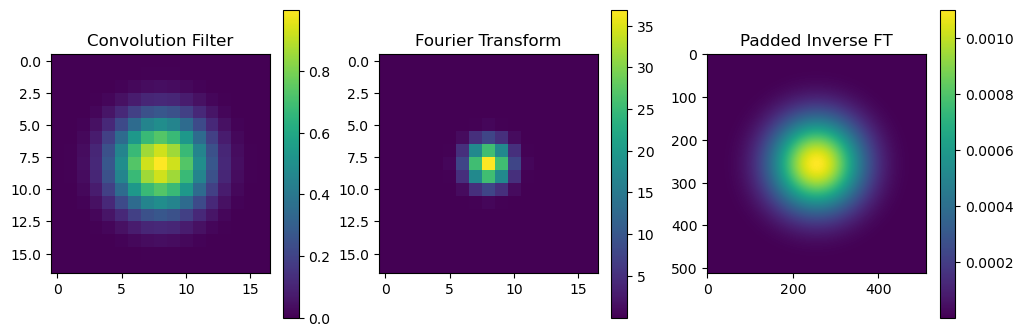

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Vitesse de la lumi√®re en m/s
lightspeed = 299792458.

# Fonction qui g√©n√®re les coefficients pour le polyn√¥me 2D (x^i * y^j)
def _gen_coeffs(x, y, order):
    ncols = (order + 1) ** 2  # Nombre total de coefficients (ordre+1)^2
    coeffs = np.empty((x.size, ncols), dtype=x.dtype)
    c = 0
    # Remplissage des coefficients pour chaque monome x^i * y^j
    for i in range(order + 1):
        for j in range(order + 1):
            coeffs[:, c] = x**i * y**j  # Calcul du monome pour chaque combinaison (i, j)
            c += 1
    return coeffs

# Fonction qui effectue un ajustement polynomial 2D par moindres carr√©s
def polyfit2d(x, y, z, order=3):
    # Utilise les coefficients g√©n√©r√©s par _gen_coeffs pour r√©soudre le syst√®me
    return np.linalg.lstsq(_gen_coeffs(x, y, order), z, rcond=None)[0]

# Fonction qui √©value un polyn√¥me 2D avec les coefficients donn√©s
def polyval2d(x, y, coeffs):
    order = int(np.sqrt(coeffs.size)) - 1  # Calcul de l'ordre √† partir du nombre de coefficients
    z = np.zeros_like(x)  # Initialisation de la sortie (z)
    c = 0
    # Calcul de la valeur du polyn√¥me pour chaque (x, y)
    for i in range(order + 1):
        for j in range(order + 1):
            z += coeffs[c] * x**i * y**j  # Addition de chaque terme du polyn√¥me
            c += 1
    return z

# Matrices P et Q utilis√©es dans le calcul de la fonction sph√©ro√Ødale
P = np.array([
    [8.203343e-2, -3.644705e-1, 6.278660e-1, -5.335581e-1, 2.312756e-1],
    [4.028559e-3, -3.697768e-2, 1.021332e-1, -1.201436e-1, 6.412774e-2]])

Q = np.array([
    [1.0000000e0, 8.212018e-1, 2.078043e-1],
    [1.0000000e0, 9.599102e-1, 2.918724e-1]])

# Fonction qui g√©n√®re le filtre sph√©ro√Ødal 2D
def spheroidal_2d(npix, factor=1.0):
    result = np.zeros((npix, npix), dtype=np.float32)  # Initialisation de la matrice de r√©sultats
    c = np.linspace(-1.0, 1.0, npix)  # Cr√©ation des coordonn√©es normalis√©es
    for y, yc in enumerate(c):
        y_sqrd = yc ** 2  # Carr√© de y
        for x, xc in enumerate(c):
            r = np.sqrt(xc**2 + y_sqrd) * factor  # Calcul de la distance radiale normalis√©e
            if r < 0.75:
                poly = 0
                end = 0.75
            elif r <= 1.00:
                poly = 1
                end = 1.00
            else:
                continue  # Si la distance est trop grande, on passe √† la prochaine valeur

            sP = P[poly]  # S√©lectionne les coefficients appropri√©s dans P
            sQ = Q[poly]  # S√©lectionne les coefficients appropri√©s dans Q
            nu_sqrd = r**2  # Calcul du carr√© de la distance radiale
            del_nu_sqrd = nu_sqrd - end**2  # Calcul de la diff√©rence par rapport √† la borne

            top = sP[0] + sum(sP[i] * del_nu_sqrd**i for i in range(1, 5))  # Calcul du num√©rateur
            bot = sQ[0] + sum(sQ[i] * del_nu_sqrd**i for i in range(1, 3))  # Calcul du d√©nominateur

            result[y, x] = (1.0 - nu_sqrd) * (top / bot)  # Calcul final de la valeur du filtre sph√©ro√Ødal
    return result

# Fonction pour ajouter du padding √† une image (centr√©e et avec des z√©ros)
def zero_pad(img, npix):
    # Calcul des dimensions du padding pour centrer l'image
    padding = [(int((npix - s) // 2), int((npix - s + 1) // 2)) for s in img.shape]
    return np.pad(img, padding, mode='constant', constant_values=0)

# Fonction pour g√©n√©rer et appliquer un filtre sph√©ro√Ødal anti-aliasing
def spheroidal_aa_filter(npix, support=11, spheroidal_support=111):
    # G√©n√®re un filtre sph√©ro√Ødal 2D
    cf = spheroidal_2d(spheroidal_support).astype(np.complex128)
    # Applique la transform√©e de Fourier
    fcf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(cf)))
    
    xc = spheroidal_support // 2
    # S√©lectionne un sous-ensemble du filtre
    start = xc - support // 2
    end = 1 + xc + support // 2
    fcf = fcf[start:end, start:end].copy()

    # Effectue un padding sur la transform√©e de Fourier pour l'adapter √† npix
    zfcf = zero_pad(fcf, int(npix))
    # Applique l'inverse de la transform√©e de Fourier
    ifzfcf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(zfcf)))
    
    return cf, fcf, ifzfcf

# Fonction qui exporte les kernels et supports dans des fichiers CSV
def write_kernels_to_csv(gridding_kernels, degridding_kernels, supports_g, supports_dg, filename, oversampling_factor):
    # Cr√©ation des noms de fichiers pour les kernels et supports
    dk_filename_r = filename + "_degridding_kernels_real_x" + str(oversampling_factor) + ".csv"
    dk_filename_i = filename + "_degridding_kernels_imag_x" + str(oversampling_factor) + ".csv"
    gk_filename_r = filename + "_gridding_kernels_real_x" + str(oversampling_factor) + ".csv"
    gk_filename_i = filename + "_gridding_kernels_imag_x" + str(oversampling_factor) + ".csv"
    ds_filename = filename + "_degridding_kernel_supports_x" + str(oversampling_factor) + ".csv"
    gs_filename = filename + "_gridding_kernel_supports_x" + str(oversampling_factor) + ".csv"

    # Exportation des parties r√©elles et imaginaires des kernels dans des fichiers CSV
    np.savetxt(dk_filename_r, degridding_kernels.real, delimiter=',')
    np.savetxt(dk_filename_i, degridding_kernels.imag, delimiter=',')
    np.savetxt(gk_filename_r, gridding_kernels.real, delimiter=',')
    np.savetxt(gk_filename_i, gridding_kernels.imag, delimiter=',')

    # Exportation des supports dans des fichiers CSV
    np.savetxt(ds_filename, supports_dg, delimiter=',')
    np.savetxt(gs_filename, supports_g, delimiter=',')

    print(f"Kernels et supports sauvegard√©s dans les fichiers CSV avec facteur de sur√©chantillonnage {oversampling_factor}")

# ======== TEST ==========
GRID_SIZE = 512  # Nombre de pixels pour le calcul
NUM_DEGRIDDING_KERNELS = 17  # Taille du support du kernel

# G√©n√©ration du filtre sph√©ro√Ødal et de ses variantes dans l'espace de Fourier
cf, fcf, ifzfcf = spheroidal_aa_filter(GRID_SIZE, NUM_DEGRIDDING_KERNELS, NUM_DEGRIDDING_KERNELS)

# Cr√©ation de kernels de test (al√©atoires)
gridding_kernels = np.random.random((NUM_DEGRIDDING_KERNELS, NUM_DEGRIDDING_KERNELS))  # Exemple de kernel de gridding
degridding_kernels = np.random.random((NUM_DEGRIDDING_KERNELS, NUM_DEGRIDDING_KERNELS))  # Exemple de kernel de degridding
supports_g = np.array([NUM_DEGRIDDING_KERNELS])  # Support pour les kernels de gridding
supports_dg = np.array([NUM_DEGRIDDING_KERNELS])  # Support pour les kernels de degridding

# Nom du fichier pour l'exportation
filename = "config/wproj_manualconj"
OVERSAMPLING_FACTOR = 16  # Facteur de sur√©chantillonnage

# Exportation des kernels et supports en CSV
write_kernels_to_csv(gridding_kernels, degridding_kernels, supports_g, supports_dg, filename, OVERSAMPLING_FACTOR)

# Visualisation des r√©sultats (filtre, transform√©e de Fourier, et inverse FFT)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Convolution Filter')
plt.imshow(cf.real)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('Fourier Transform')
plt.imshow(np.abs(fcf))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Padded Inverse FT')
plt.imshow(np.abs(ifzfcf))
plt.colorbar()

plt.show()

# merci chatgpt

#### Step 4: run the dataflow executable

In [9]:
import os
import subprocess

# Chemin vers le dossier dataflow
dataflow_directory = "code"

# V√©rifie si on est d√©j√† dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le r√©pertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est d√©j√† dans le r√©pertoire {dataflow_directory}.")

EXECUTABLE = "./STD_DEGRID"

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run(EXECUTABLE, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")
    
os.chdir("..")
print(os.getcwd())

Le r√©pertoire actuel est /home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator. Changement vers code...
Lancement : ./STD_DEGRID
Le fichier doit contenir un nombre pair de valeurs (x, y).
Grille d'entr√©e 0: 0.000000 + 0.000000i
Grille d'entr√©e 1: 0.000000 + 0.000000i
Grille d'entr√©e 2: 0.000000 + 0.000000i
Grille d'entr√©e 3: 0.000000 + 0.000000i
Grille d'entr√©e 4: 0.000000 + 0.000000i
UPDATE >>> Loading degridding kernel support file from config/wproj_manualconj_degridding_kernel_supports_x16.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is -2147483648...

UPDATE >>> Loading kernel files file from config/wproj_manualconj_degridding_kernels_real_x16.csv real and config/wproj_manualconj_degridding_kernels_imag_x16.csv imaginary...

Degridding visibilities using FFT degridder
UPDATE >>> Image degridded successfully
Visibilit√© 0: 0.000000 + 0.000000i
Visibilit√© 1: 0.000000 + 0.000000i
Visibilit√© 2: 0.000000 + 0.000000i
Visibilit√© 3: 0

L'√©tape suivante n'est pas necessaire, c'est juste pour v√©rifier que j'ai pas merd√© √† converir *.fits en *.csv

2


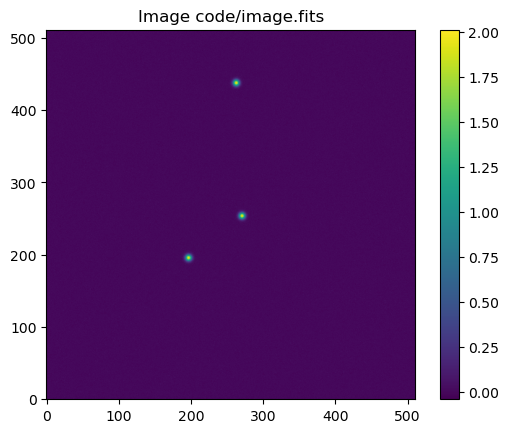

In [10]:
import numpy
import sys
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt

def write_nparr_to_fits(data, filename):
    hdu = fits.PrimaryHDU(data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)
    hdulist.close()

def display_fits_image(fits_file):
    # Charger les donn√©es du fichier FITS
    hdulist = fits.open(fits_file)
    data = hdulist[0].data  # Les donn√©es de l'image sont dans la premi√®re extension
    print(data.ndim)
    hdulist.close()

    # Affichage de l'image avec matplotlib
    plt.imshow(data, cmap='viridis', origin='lower')
    plt.colorbar()  # Ajoute une barre de couleur pour l'√©chelle des intensit√©s
    plt.title(f"Image {fits_file}")
    plt.show()

IMAGE = "code/image.csv"
FITS = "code/image.fits"
delimiter = ","

result = numpy.genfromtxt(IMAGE, delimiter=delimiter)[:,:-1]  # Ignorer la derni√®re colonne si n√©cessaireresult = numpy.flip(result)

write_nparr_to_fits(result, FITS)
display_fits_image(FITS)

#### Step 5: Visualize the generated visibilities

Min u : -8323.353516, Max u : 6575.183105
Min v : -7481.304688, Max v : 7416.437988
Min r√©el : -0.019824, Max r√©el : 0.023588
Min imaginaire : -0.02044, Max imaginaire : 0.018225
Maximum d'amplitude : 0.024123782456323056


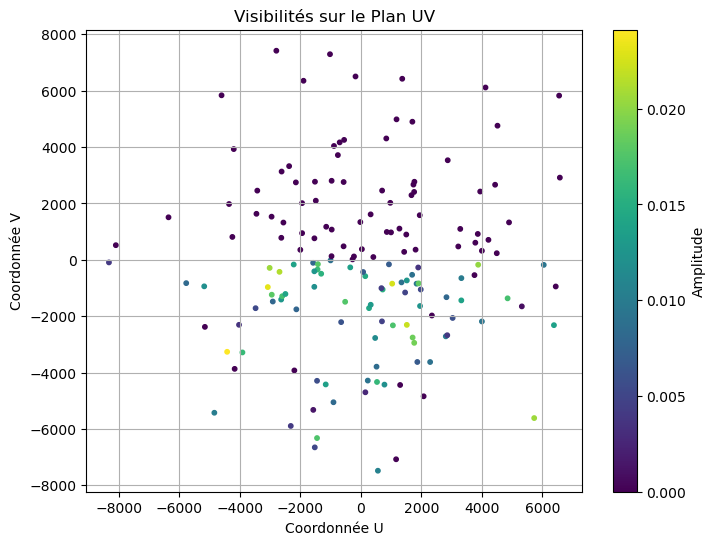

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Charger les donn√©es depuis le fichier CSV
visibility_data = np.genfromtxt("code/vis.csv", delimiter=' ', skip_header=1)


# Extraire les coordonn√©es u et v 
u_coord = visibility_data[:, 0]  # Premi√®re colonne : coordonn√©es u
v_coord = visibility_data[:, 1]  # Deuxi√®me colonne : coordonn√©es v

print(f"Min u : {np.min(u_coord)}, Max u : {np.max(u_coord)}")
print(f"Min v : {np.min(v_coord)}, Max v : {np.max(v_coord)}")


# Extraire les parties r√©elle et imaginaire des visibilit√©s
real_part = visibility_data[:, 3]  # 4e colonne : partie r√©elle
imag_part = visibility_data[:, 4]  # 5e colonne : partie imaginaire

print(f"Min r√©el : {np.min(real_part)}, Max r√©el : {np.max(real_part)}")
print(f"Min imaginaire : {np.min(imag_part)}, Max imaginaire : {np.max(imag_part)}")

# Calculer l'amplitude
amplitude = np.sqrt(real_part**2 + imag_part**2)

# **Afficher le maximum d'amplitude**
max_amplitude = np.max(amplitude)
print(f"Maximum d'amplitude : {max_amplitude}")


# Tracer les visibilit√©s sur le plan UV
plt.figure(figsize=(8, 6))
plt.scatter(u_coord, v_coord, c=amplitude, cmap='viridis', s=10)  # Taille et couleur selon l'amplitude
plt.colorbar(label='Amplitude')  # Ajouter une barre de couleurs pour l'amplitude
plt.title("Visibilit√©s sur le Plan UV")
plt.xlabel("Coordonn√©e U")
plt.ylabel("Coordonn√©e V")
plt.grid(True)
plt.show()
